DataSet : https://www.kaggle.com/datasets/jessicali9530/kuc-hackathon-winter-2018

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from textblob import TextBlob

In [6]:
train_data = pd.read_csv("drugsComTrain_raw.csv")
test_data = pd.read_csv("drugsComTest_raw.csv")

# 1. Data Preprocessing

In [7]:
train_data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [9]:
test_data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [8]:
train_data.shape

(161297, 7)

In [10]:
test_data.shape

(53766, 7)

In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     161297 non-null  int64 
 1   drugName     161297 non-null  object
 2   condition    160398 non-null  object
 3   review       161297 non-null  object
 4   rating       161297 non-null  int64 
 5   date         161297 non-null  object
 6   usefulCount  161297 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 8.6+ MB


In [14]:
train_data.duplicated().sum()

0

In [15]:
test_data.duplicated().sum()

0

In [16]:
train_data.dropna(subset=['condition','drugName'], inplace=True)
test_data.dropna(subset=['condition','drugName'], inplace=True)

# 2. Text Preprocessing

In [20]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100)

train_reviews_tfidf = tfidf_vectorizer.fit_transform(train_data['review'].fillna('')).toarray()

test_reviews_tfidf = tfidf_vectorizer.transform(test_data['review'].fillna('')).toarray()

In [21]:
# Add TF-IDF features to the original datasets

train_tfidf_df = pd.DataFrame(train_reviews_tfidf, columns=[f'tfidf_{i}' for i in range(train_reviews_tfidf.shape[1])])

test_tfidf_df = pd.DataFrame(test_reviews_tfidf, columns=[f'tfidf_{i}' for i in range(train_reviews_tfidf.shape[1])])

# 3. Feature Encoding with Handling Unseen Labels in Test Data


In [24]:
# Function to handle unseen labels during encoding
def encode_with_unseen_handling(label_encoder, data, column_name):
    try:
        return label_encoder.transform(data[column_name])
    except ValueError as e:
        unseen_labels = [label for label in data[column_name].unique() if label not in label_encoder.classes_]
        label_encoder.classes_ = np.append(label_encoder.classes_, unseen_labels)
        return label_encoder.transform(data[column_name])

In [25]:
# Encoding 'condition' and 'drugName'

label_encoder_condition = LabelEncoder()
train_data['condition_encoded'] = label_encoder_condition.fit_transform(train_data['condition'])
test_data['condition_encoded'] = encode_with_unseen_handling(label_encoder_condition, test_data, 'condition')

label_encoder_drug = LabelEncoder()
train_data['drugName_encoded'] = label_encoder_drug.fit_transform(train_data['drugName'])
test_data['drugName_encoded'] = encode_with_unseen_handling(label_encoder_drug, test_data, 'drugName')

# 4. Scaling Features


In [26]:
scaler = StandardScaler()

train_data[['rating', 'usefulCount']] = scaler.fit_transform(train_data[['rating', 'usefulCount']])

test_data[['rating', 'usefulCount']] = scaler.transform(test_data[['rating', 'usefulCount']])

# 5. Calculate Sentiment Scores


In [28]:
def calculate_sentiment(text):
    analysis = TextBlob(text)
    
    # Return polarity score (-1 to 1) as sentiment score (-1 Negative, 0 Netural, 1 Positive)
    return analysis.sentiment.polarity

In [29]:
# Apply sentiment calculation to the reviews

train_data['sentiment_score'] = train_data['review'].fillna('').apply(calculate_sentiment)

test_data['sentiment_score'] = test_data['review'].fillna('').apply(calculate_sentiment)

# 6. Feature Selection for Clustering


In [30]:
# Selecting features for clustering

features_for_clustering_train = train_data[['condition_encoded', 'drugName_encoded', 'rating', 'usefulCount', 'sentiment_score']]

features_for_clustering_test = test_data[['condition_encoded', 'drugName_encoded', 'rating', 'usefulCount', 'sentiment_score']]

In [35]:
features_for_clustering_train.head()


,condition_encoded,drugName_encoded,rating,usefulCount,sentiment_score
0,466,3198,0.612438,-0.030106,0.000000
1,73,1428,0.306842,4.495679,0.168333
2,165,1851,-0.609946,-0.304396,0.067210
3,165,2280,0.306842,-0.496399,0.179545
4,574,515,0.612438,0.244184,0.194444


# 7. Determine Optimal Number of Clusters using Elbow Method


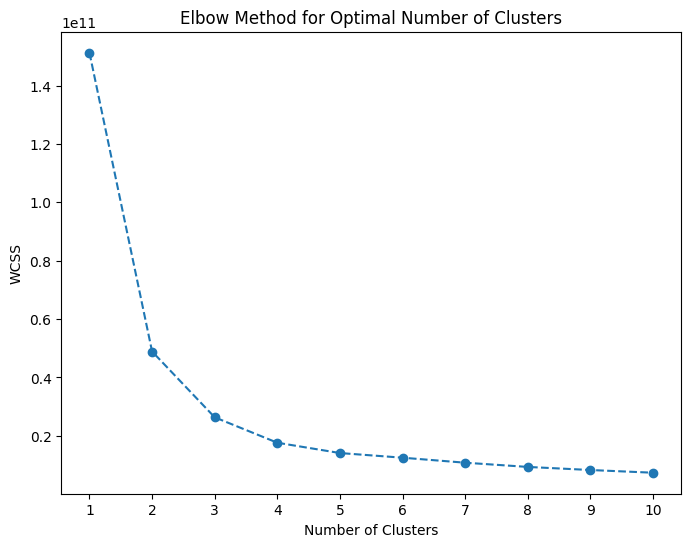

In [32]:
wcss = []  

for i in range(1, 11):  
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(features_for_clustering_train)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xticks(range(1,11))
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [37]:
def knee_locator(wcss):
    # Calculate the differences in WCSS
    diff_wcss = np.diff(wcss)
    
    # Calculate the ratios of consecutive differences
    ratios = diff_wcss[:-1] / diff_wcss[1:]
    
    # Find the index where the ratio is highest (the "knee" point)
    knee_idx = np.argmax(ratios) + 2
    
    return knee_idx

knee_locator(wcss)

2

# 8. Train the KMeans Model 


In [38]:
optimal_clusters = 2  

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)

kmeans.fit(features_for_clustering_train)

KMeans(n_clusters=2, random_state=42)

# 9. Predict Clster For Test Data

In [39]:
test_data['cluster'] = kmeans.predict(features_for_clustering_test)

# 10. Recommend Drugs Based on a Specific Condition


In [44]:
def recommend_drug(condition):
    # Filter data based on the specific condition
    condition_data = test_data[test_data['condition'] == condition].copy() 

    if condition_data.empty:
        return "No data available for this condition"

    # Calculate combined score
    condition_data.loc[:, 'combined_score'] = condition_data[['rating', 'usefulCount', 'sentiment_score']].sum(axis=1)

    # Find the drug with the highest combined score
    recommended_drug = condition_data.loc[condition_data['combined_score'].idxmax()]

    return recommended_drug['drugName']

condition = input("Enter Patient Condition :")
recommended_drug = recommend_drug(condition)
print(f"Condition : {condition}, Recommended Drug : {recommended_drug}")

Condition : Depression, Recommended Drug : Sertraline


In [56]:
def recommend_drug(condition):
    condition_data = test_data[test_data['condition'] == condition].copy() 

    if condition_data.empty:
        return "No data available for this condition"

    condition_data.loc[:, 'combined_score'] = condition_data[['rating', 'usefulCount', 'sentiment_score']].sum(axis=1)

    top_3_drugs = condition_data.nlargest(4, 'combined_score').drop_duplicates('drugName')

    return top_3_drugs['drugName'].tolist()

condition = input("Enter Patient Condition :")
recommended_drugs = recommend_drug(condition)
print(f"Condition : {condition}, Recommended Drugs : {recommended_drugs}")

Condition : Diabetes, Type 2, Recommended Drugs : ['Liraglutide', 'Metformin', 'Amaryl']
